#Reconstruction of palaeotopography from low-temperature thermochronological data

This notebook compares a 2D numerical-simulation to the quasi-analytic solution for isotherm perturbation, given by Wang Wei* and Zhou Zuyi: "Reconstruction of palaeotopography from low-temperature thermochronological data"

##quasi-analytic model

Because heat conduction in solids can be approximated as a linear physical process, the total perturbation of the thermal field caused by the topography can be adequately approximated by the sum of the perturbations caused by each of the components of the Fourier series. The perturbation caused by a periodic topography with small amplitude has been shown to be proportional to the amplitude of the topography, and to decay exponentially with depth (Turcotte et al. 1982). The steady-state solution for topography of constant geometry can therefore be expressed as



$$T(x,y) = T_0(y) + \sum_{n=0}^{N} \left[ 
   a_{n}\,\cos \left(\frac{2n\pi x}{\lambda} \right) \\
   + b_{n} \,\sin \left(\frac{2n\pi x}{\lambda}\right) \right] e^{ym_n} \left(\frac{\partial T_0(y)}{\partial y_{y=0}} - \phi\right)$$
   
Where

$$m_n = \frac{1}{2} \left(-u/k - \sqrt{(u/k)^2 + (4n \pi/\lambda)^2}  \right)$$

$\lambda$ is the width of the domain

$\lambda/n$ is the wavelength of the perturbation

$u$ is exhumation rate

$k$ is thermal diffusivity

$\phi$ is the lapse rate

$T_0(y)$ describes the geotherm with erosion at a steady rate, in the absence of any surface perturbations, and can be fixed according to the temperature at the surface and at the lower boundary of a slab

$$T_0(y) = T_s + \beta\left[1-\exp\left(-\frac{y}{h}\right) \right] + \gamma\left[1-\exp\left(-\frac{u}{\kappa}y\right) \right]$$

Which in the absence of heat-production ,reduces to:

$$T_0(y) = T_s + \gamma\left[1-\exp\left(-\frac{u}{\kappa}\right) \right]$$

$$\gamma = \frac{(T_L-T_s) - \beta \left[ 1-\exp\left( - \frac{L}{h}\right)\right]}{1-\exp \left(-\frac{u}{k} L\right)}$$

Which in the absence of heat-production ,reduces to:

$$\gamma = \frac{(T_L-T_s)}{1- \exp \left(-\frac{u}{k} L\right)}$$

For a box with surface temperature $T_s$ and constant temperature $T_L$ at depth $L$.

$h$ is the depth at which the heat production drops to
$1/e$ of the surface value $A_s$  (we don't need these parameters for no heat production).


In [1]:
%pylab inline
import math



Populating the interactive namespace from numpy and matplotlib


In [2]:
##Key Parameters (similar to ....Wei & Zuyi)

#basal temp

TL = 2500.

Tmsl = 25. #rough average mean sea level temp for Bhutan Lat.


res = 1.  #Resolution in Kms, will dictate interpolation as well as UW resolution. 

#UW resolution, points for topographic interpolation

L = 100.  #This is the vertical length (depth) in the model, 
#amp = 1.
wavelength = 30.

#exhumation / denudation  (0- 0.5 km / Ma)
u = 0.25
lapse = -4.5 #C/km
DTDY = 25.

#thermal diffusivity km^2 Ma-1 conversion used is 1m^2 s-2 = (365*24*3600)km^2 Ma-1
kappa = 1e-6*(365*24*3600)
kappa


31.535999999999998

##DFT refresher

There often seems to be differing notation regarding where the normalization factor $1/N$ goes. I referred to the notes here: http://www.nbtwiki.net/doku.php?id=tutorial:the_discrete_fourier_transformation_dft#.VgD33p2qqko and http://www.whydomath.org/node/hearing/discreteFourierTransform.html

This definition seems to be appropriate for the scipy FFT module, as shown bewlow where the original signal is synthesised in terms of the sin and cosine terms. 

Using $x$ for the spatial coordinate, and $n$ the coordinate of the transform pair (as in Wang Wei* and Zhou Zuyi:),  The discrete Fourier transform is given by:

$$ F_n = \sum_{x=0}^{N-1} f_x e^{-2\pi i x n / N}$$ 

the inverse transform is:

$$ f_x = \frac{1}{N} \sum_{n=0}^{N-1} F_n e^{2\pi i x n / N}$$ 

The longest full sinusoidal cycle that can be captured by the N data points consists of N samples per cycle. The smalles frequency above zero in the DFT is the reciprocal, $f_1 = 1/N$ cycles per sample


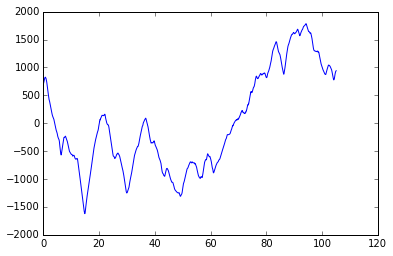

In [3]:
#topolist = []
#amp = 1.
#xlist = np.arange(0, W, 1)
#xlist = np.array(horizontals)


#topo = amp*(np.sin(2. * np.pi * xlist/(wavelength))) + 0.5 * np.random.randn(xlist.size)

topo = np.loadtxt('topoh.csv', skiprows=1,delimiter=',')

mean_elv = topo[:,2].mean()
max_elv = topo[:,2].max()
min_elv = topo[:,2].min()
topo[:,2] -= abs(topo[:,2].mean())

dom_width = topo[:,0].max() - topo[:,0].min()

pyplot.plot(topo[:,0],topo[:,2])

In [4]:
print(min_elv, mean_elv,max_elv)

(749.13131910000004, 2369.8921038768931, 4153.8195910000004)


In [5]:
#Set the model domain width, number of points in interpolated topography, FFT, UW elements
W = topo[:,0].max()
npts = int(np.ceil(W/res))

#Set the temperature at the mean elevation
TS = Tmsl  + lapse*mean_elv/1e3
print(TS)

14.3354855326


In [6]:
dom_width

105.00042089999999

In [7]:
from scipy.interpolate import interp1d

In [8]:
#topo[:,0].max() - topo[:,0].min()
elev = interp1d(topo[:,0], topo[:,2])
newx = np.linspace(topo[:,0].min(), topo[:,0].max(), npts)
newy = elev(newx)/1000.
#newy -= abs(newy.min())

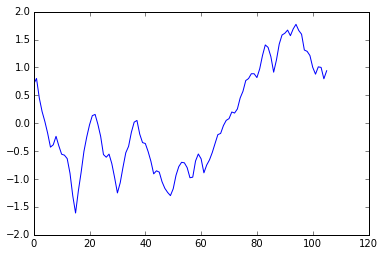

In [9]:
pyplot.plot(newx,newy)

In [10]:
from scipy import fftpack
sample_freq = fftpack.fftfreq(newy.size, d=1)
sig_fft = fftpack.fft(newy)

#trunc = 50.
yinv = fftpack.ifft(sig_fft)

In [11]:
sig_fft.shape

(106,)

In [12]:
# synthesise the signal using cos and sin
def synth(ffcs, freqs=False):
    """
    experimental function to test the FFT conventions in Scipy, 
    A (complex valued) ffcs object is synthesised using addition of sin and cosines (Euler's formula)
    par "freqs" can be added to reduce the number of terms in the synthesis
    """
    x = []
    N = len(ffcs)
    #N = (topo[:,0].max() - topo[:,0].min()
    #print a0
    if not freqs:
        freqs = len(ffcs)
    for k in range(freqs):
        xk = [(1./N)*((np.real(ffcs[k])*np.cos((2.*np.pi*n*k)/(N))) - np.imag(ffcs[k])*np.sin((2.*np.pi*n*k)/(N))) for n in range(N)]
        #xk.append(v)   
        x.append(xk)
    arr = np.array(x)
    return np.sum(arr, axis = 0.)

In [13]:
toposynth1 = synth(sig_fft, freqs = 2)
toposynth = synth(sig_fft)

/Users/dansandiford/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


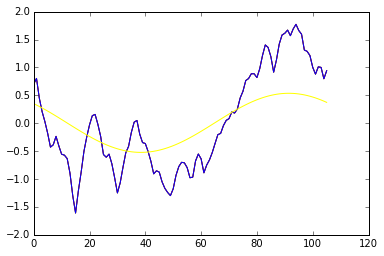

In [14]:
pyplot.plot(newx, newy, color="green")
pyplot.plot(newx, yinv, color="red")
pyplot.plot(newx, toposynth)
pyplot.plot(newx, toposynth1, color='yellow')

In [15]:
def Tflat(y, TL, TS, L, u, kappa, lapse):
    if y < 0:
        t = TS + (-1*y*lapse)
    else:
        gam = (TL-TS)/(1-np.exp(-L*(u/kappa)))
        t = TS + gam*(1-np.exp(-1*(u/kappa)*y))
    return t

In [16]:
#Check Tflat is working (i.e. no topography, no exhumation):
uc = 1e-8
geotherm=(TL-TS)/L
print(geotherm)
depth = 10.
expected = TS + depth*geotherm
result = Tflat(depth, TL, TS, L, uc, kappa, lapse)
print(expected, result)

24.8566451447
(262.90193697929863, 262.90193697929863)


In [17]:
 def analytic_geotherm(y,width, ffcs, TL, TS, L, u, kappa,dtdy,lapse):
    #######
    #Get T0
    #######
    #gam = (TL-TS)/(1-np.exp(-L*(u/kappa)))
    #T0 = TS + gam*(1-np.exp(-1*(u/kappa)*y))
    T0 = Tflat(y, TL, TS, L, u, kappa, lapse)
    #######
    #Compute pertubation from Fourier coeffcients
    #######
    t = []
    N = len(ffcs)
    for n in range(len(ffcs)):
        mn = 0.5*((-1*u/kappa) - np.sqrt((u/kappa)**2 + ((4*n*np.pi)/(width))**2))
        xk = [(1./N)*((np.real(ffcs[n])*np.cos((2.*np.pi*j*n)/(N))) - np.imag(ffcs[n])*np.sin((2.*np.pi*j*n)/(N))) for j in range(N)]
        #print mn
        expterm = np.exp(mn*y)*(dtdy - lapse)
        temppert = [i*expterm for i in xk]
        t.append(temppert)
    arr = np.array(t)
    tp = np.sum(arr, axis = 0.)
    tp += T0
    return tp


In [18]:
#Create y values for topographic array, x values are taken from the number of samples in the profile
ys = np.linspace(0,6, 100)
a = np.zeros((ys.shape[0] , npts))

In [19]:
for index, y in enumerate(ys):
    T = analytic_geotherm(y,dom_width, sig_fft, TL, TS, L, u, kappa, DTDY, lapse)
    a[index,:] = T
    
#Set any negative values of a to zero

a[a < 0] = 0

In [20]:
# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
     def __repr__(self):
         str = '%.1f' % (self.__float__(),)
         if str[-1]=='0':
             return '%.0f' % self.__float__()
         else:
             return '%.1f' % self.__float__()

In [21]:
#Our Fourier expansion is around the Mean elevation. For plotting we want the true elevation
zerolineelev = -1*(ys[0] - mean_elv/1000.)
bottomelev = -1*(ys[-1] - mean_elv/1000.)
print(zerolineelev, bottomelev)

(2.369892103876893, -3.630107896123107)


In [22]:
2.3*25 + 14

71.5

/Users/dansandiford/anaconda/lib/python2.7/site-packages/matplotlib/text.py:52: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if rotation in ('horizontal', None):
/Users/dansandiford/anaconda/lib/python2.7/site-packages/matplotlib/text.py:54: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif rotation == 'vertical':


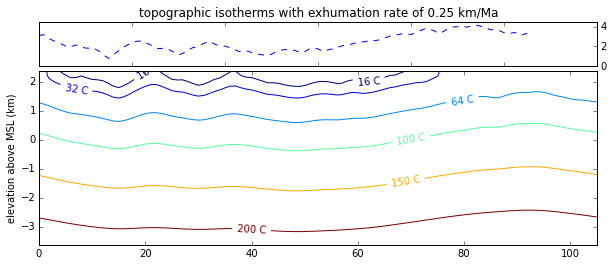

In [23]:
fig1 = plt.figure(figsize=[10,4])
#
gs = GridSpec(100,400)

axT = fig1.add_subplot(gs[0:20,0:400])
plt.title('topographic isotherms with exhumation rate of ' + str(u) + ' km/Ma')
axT.plot(toposynth+(mean_elv/1e3), '--')
axT.xaxis.set_major_formatter(plt.NullFormatter())
axT.yaxis.tick_right() 
axT.yaxis.set_ticks([0,2,4])
axMain = fig1.add_subplot(gs[22:,0:400])
levels = [16, 32, 64, 100, 150, 200]
CS = axMain.contour(flipud(a), levels, extent=[0, dom_width, bottomelev, zerolineelev], aspect='auto')
CS.levels = [nf(val) for val in CS.levels ]
fmt = '%r' + ' C'
plt.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
plt.ylabel('elevation above MSL (km)')

    

Figure caption: Figure shows isotherms calculated below the mean topographic level, using the semi-analytic approach of W. WEI & Z. ZUYI. 

In [24]:
#Create y values for topographic array, x values are taken from the number of samples in the profile
ys = np.linspace(0,6, 100)
a = np.zeros((ys.shape[0] , npts))

#loop through different exhumation rates, and plot variation of the 100 degree isotherm 
isotherms = []
exhume_vals = np.linspace(0.01,0.5, 6)
for vel in exhume_vals:
    for index, y in enumerate(ys):
        T = analytic_geotherm(y,dom_width, sig_fft, TL, TS, L, vel, kappa, DTDY, lapse)
        a[index,:] = T
    #Set any negative values of a to zero
    a[a < 0] = 0
    fig = plt.figure()
    CS = plt.contour(flipud(a), levels=[100.], extent=[0, dom_width, -6., 0.], aspect='auto')
    out = CS.collections[0].get_paths()
    arr = out[0].vertices[:,1]
    fig.clf()
    isotherms.append(arr)

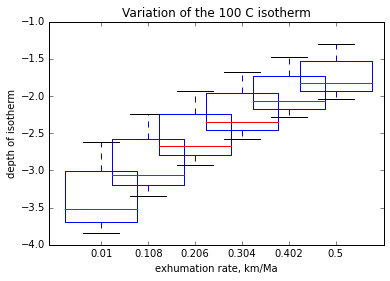

In [25]:
figure(1)
boxplot(isotherms, positions=exhume_vals)
labels = exhume_vals
plt.xlim(-0.1,0.6)
#xticks(range(0,0.5),labels, rotation=15)
xlabel('exhumation rate, km/Ma')
ylabel('depth of isotherm')
title('Variation of the 100 C isotherm')

In [26]:
effective_geotherm = [abs(100./i) for i in isotherms]

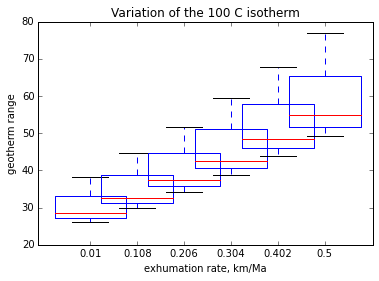

In [27]:
figure(1)
boxplot(effective_geotherm, positions=exhume_vals)
labels = exhume_vals
plt.xlim(-0.1,0.6)
#xticks(range(0,0.5),labels, rotation=15)
xlabel('exhumation rate, km/Ma')
ylabel('geotherm range')
title('Variation of the 100 C isotherm')

##Underworld model

In [28]:
# Stagnant lid convection model

%matplotlib inline

import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import matplotlib.pylab as pyplot
import numpy as np

In [29]:
dim = 2
meshX = int(npts + 1)
meshY = int(L + 1)
maxX = W 
maxY = L


elementMesh = uw.mesh.FeMesh_Cartesian( elementType='Q1/dQ0',
                                      elementRes=(meshX,meshY), 
                                      minCoord=(0.,0.), maxCoord=(maxX,maxY )  )


linearMesh   = elementMesh
constantMesh = elementMesh.subMesh

xCoordFn = fn.input()[0]
yCoordFn = fn.input()[1]

In [30]:
elementMesh.maxCoord
abs(newy.min())

1.6094078033077497

In [31]:
with elementMesh.deform_mesh():
    for index, coord in enumerate(elementMesh.data):
        y0 = coord[1]
        pert = elev(coord[0])/1000.
        elementMesh.data[index][1] = y0 + ((y0/maxY)*pert)

In [32]:
print(elementMesh.maxCoord, elementMesh.data[:,1].max())

((105.00042089999999, 100.0), 101.78339148083158)


In [33]:
coordinate = fn.input()

In [34]:
elev(coord[0])/1000.

0.94019034612310681

In [35]:
dim = 2

# create & zero fevariables
velocityField    = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=dim )
temperatureField = uw.fevariable.FeVariable( feMesh=linearMesh,   nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
temperatureField.data[:] = 0.

#Initial Temperature and BCs


In [36]:
toptemp = TS
deltemp = TL

In [37]:
#Initial temperature field is the no-topography solution, extended above/below side of the mean elevation temp (~14 C)

for index, coord in enumerate(elementMesh.data):
    #temperatureField.data[index] = TL
    temperatureField.data[index] = Tflat((maxY - coord[1]), TL, TS, L, u, kappa, lapse)

In [38]:

IWalls = elementMesh.specialSets["MinI_VertexSet"] + elementMesh.specialSets["MaxI_VertexSet"]
JWalls = elementMesh.specialSets["MinJ_VertexSet"] + elementMesh.specialSets["MaxJ_VertexSet"]
# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              nodeIndexSets=(JWalls,) )

In [39]:
# lets ensure temp boundaries are still what we want as the IC above might have set slightly different values
# on the boundaries
for index in elementMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = toptemp + deltemp
for index in elementMesh.specialSets["MaxJ_VertexSet"]:
    elevation = elementMesh.data[index][1]
    dy = elevation - L
    dtemp = TS + dy*lapse
    temperatureField.data[index] = dtemp

In [40]:
topbound = elementMesh.specialSets["MaxJ_VertexSet"]
bottombound = elementMesh.specialSets["MinJ_VertexSet"]
heights = coordinate.evaluate(topbound)[:,1]
horizontals = coordinate.evaluate(topbound)[:,0]

In [41]:
#horizontals.shape

In [42]:
elementMesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

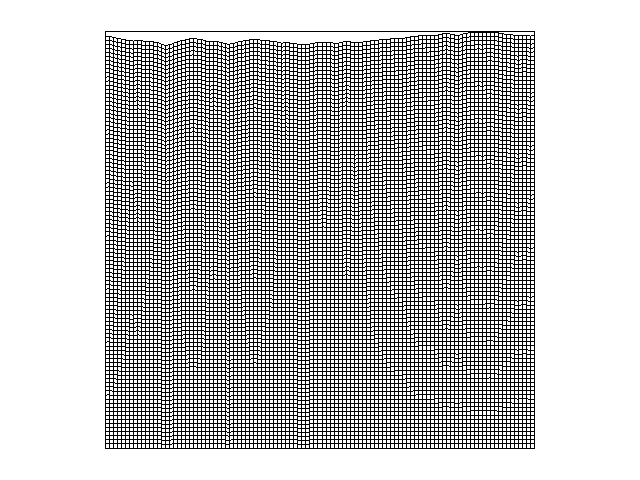

In [43]:
meshfig = plt.Figure()
meshfig.Mesh(elementMesh, colourBar=False)

meshfig.show()

In [44]:
#figtemp = plt.Figure()
#figtemp.Surfa                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   ce(temperatureField, elementMesh)
#figtemp.Mesh(elementMesh, colourBar=False)
#figtemp.show()

##Setup advection - diffusion system


In [45]:
#Check vertical velocity is still right
print(u)

0.25


In [46]:
velocityField.data[:] = [0,u]
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=kappa, conditions=[tempBC,] )

In [47]:
#print "timestep in years: " + str(advDiff.get_max_dt()*1e6)
#advDiff.get_max_dt()

##Solve

In [48]:
step = 0
areaint = uw.utils.Integral(1.,linearMesh)
area = areaint.integrate()[0]
area

10500.079660363686

In [49]:
dt = 0.001 #thousand years
t0 = temperatureField.copy()
t1 = temperatureField.copy()
tol = 1.
tolcheck = []
realtime = 0.

#while tol > 1e-1:
while step < 4000:
    t0.data[:] = np.copy(temperatureField.data[:])
    #dt = advDiff.get_max_dt()
    advDiff.integrate(dt)
    t1.data[:] = np.copy(temperatureField.data[:])
    intField = t1 - t0
    tempint = uw.utils.Integral(intField, elementMesh)
    tol = tempint.integrate()[0]/area 
    tolcheck.append(tol)
    realtime += dt
    step += 1
    if step % 100 == 0:
        print step, tol
        

100 0.00129225775978
200 0.000927152228509
300 0.000759915877993
400 0.000659408207427
500 0.000590666018453
600 0.000539911427474
700 0.000500486844943
800 0.000468735131213
900 0.000442460581742
1000 0.000420255620218
1100 0.000401171221645
1200 0.000384541364381
1300 0.000369883132841
1400 0.000356836758536
1500 0.000345128016358
1600 0.000334543755436
1700 0.000324915468848
1800 0.000316107958182
1900 0.000308011326336
2000 0.000300535202587
2100 0.000293604500207
2200 0.000287156248297
2300 0.000281137190604
2400 0.000275501941251
2500 0.000270211550882
2600 0.000265232379532
2700 0.000260535201656
2800 0.000256094488787
2900 0.000251887829659
3000 0.000247895457693
3100 0.000244099863142
3200 0.000240485472572
3300 0.000237038382181
3400 0.00023374613471
3500 0.000230597531719
3600 0.00022758247476
3700 0.000224691830358
3800 0.000221917314745
3900 0.000219251394932
4000 0.000216687203506


##Set up isosurface swarm

* Because the temperature field corresponds to an irregular mesh, we're going to use swarms to interpolate the values at fixed positions

In [50]:
npts+1

107

In [52]:
xps = np.linspace(0, W, npts+2)
yps = np.zeros(npts+2)
yps[:] = 95. #Which corresponds to a depth of L - d.

isoswarm = uw.swarm.Swarm( feMesh=elementMesh )
isoswarm.add_particles_with_coordinates(np.array((xps,yps)).T)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107], dtype=int32)

In [53]:
isotherm = temperatureField.evaluate(isoswarm)
isotherm.shape

(108, 1)

##Plot underworld vs. Analytic solution at a single depth

In [54]:
#horizontals.shape

In [67]:
#Get the analytic solution and the value in the absence of topography

depth = 5

notop = Tflat(depth, TL, TS, L, u, kappa, lapse)
analytic = analytic_geotherm(depth,dom_width, sig_fft, TL, TS, L, u, kappa, DTDY, lapse)
#data = np.flipud(tempnp[:,:,0])
#numeric = data[depth,:]

In [68]:
meshX

107

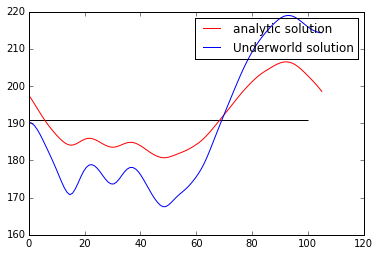

In [69]:
#data = np.flipud(tempnp[:,:,0])
#for i in depths:

pyplot.plot(newx, analytic, color= "red", label="analytic solution")
pyplot.plot(horizontals, isotherm, color= "blue", label="Underworld solution")
pyplot.legend()
pyplot.hlines(notop,0,100 )

##Create a regular array of Underworld solution, and get isotherms

In [58]:
todepth = 10
vertpts = 20.
valley = L + newy.min()
ys = np.linspace(valley, valley - todepth, vertpts)
xs = np.linspace(0 , W, vertpts*floor((W/todepth)))


In [59]:
X, Y = np.meshgrid(xs, ys)

In [60]:
depthswarm = uw.swarm.Swarm( feMesh=elementMesh )
depthswarm.add_particles_with_coordinates(np.array((X.ravel(),Y.ravel())).T)

array([   0,    1,    2, ..., 3997, 3998, 3999], dtype=int32)

In [61]:
#fig1 = plt.Figure()
#fig1.Points( swarm=depthswarm, pointSize=2, colour='blue', colourBar = False)
#fig1.show()

In [62]:
regtemps = temperatureField.evaluate(depthswarm)

In [63]:
temparray = regtemps.reshape(ys.shape[0], xs.shape[0])

In [64]:
zerolineelev = mean_elv/1000. + newy.min()
bottomelev = zerolineelev - todepth

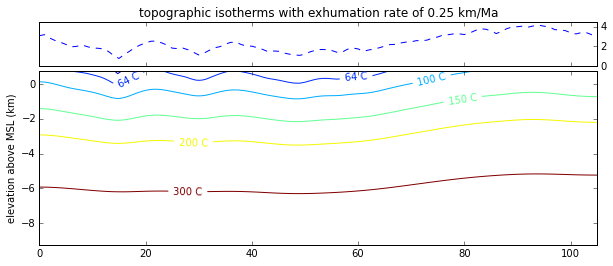

In [65]:
fig1 = pyplot.figure(figsize=[10,4])
#
gs = GridSpec(100,400)

axT = fig1.add_subplot(gs[0:20,0:400])
pyplot.title('topographic isotherms with exhumation rate of ' + str(u) + ' km/Ma')
axT.plot(toposynth+(mean_elv/1e3), '--')
axT.set_xlim(0, W)
axT.xaxis.set_major_formatter(pyplot.NullFormatter())
axT.yaxis.tick_right() 
axT.yaxis.set_ticks([0,2,4])
axMain = fig1.add_subplot(gs[22:,0:400])
levels = [16, 32, 64, 100, 150, 200, 300]
CS = axMain.contour(flipud(temparray), levels, extent=[0, W, bottomelev, zerolineelev], aspect='auto')
CS.levels = [nf(val) for val in CS.levels ]
fmt = '%r' + ' C'
pyplot.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)
pyplot.ylabel('elevation above MSL (km)')